# Final project

    a) Project description
    b) Solution to exercises (1-3)
        b.1) Comments and final considerations

The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

# Solution to Exercises

In [48]:
#%pylab inline
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *
#import argparse

In [60]:
## for .py file
#parser = argparse.ArgumentParser()
#parser.add_argument("eps", default=0.001)
#parser.add_argument("degree",type=int, default=1)
#parser.add_argument("resolution",type=int, default=1000)
#args = parser.parse_args()
#print(args)

In [16]:
# Step 1.1

def f(eta):
    return (eta**2 * (eta-1)**2)

def F(eta):
    # Fill in with the derivative of the double well potential function
    return 2.*eta*(eta-1)**2 + 2.*eta**2 * (eta-1)

In [18]:
# Step 1.2

def compute_basis_functions(spoints, degree):   
    basis = []
    dbasis = []
    
    for i in range(len(spoints)):
        c = spoints*0
        c[i] = 1
        bi = PPoly.from_spline(splrep(spoints,c,k=degree))
        
        basis.append(bi)
        dbasis.append(bi.derivative(1))
    return basis 

In [19]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    intervals = np.unique(basis[0].x) 
    qp, w = np.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    qp = (qp+1)/2 # Rescale 
    w /= 2
    
    # Replicate thorugh intervals
    h = np.diff(intervals)
    Q = np.array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    W = np.array([w*h[i] for i in range(len(h))]).reshape((-1,))
    return Q, W

In [20]:
# Step 1.4

def compute_system_matrices(basis, global_quadrature, global_weights):
    
    dbasis = [bi.derivative(1) for bi in basis]
    
    Bq = np.array([basis[i](global_quadrature) for i in range(len(basis))]).T
    dBq = np.array([dbasis[i](global_quadrature) for i in range(len(basis))]).T
    M = np.einsum('qi, q, qj', Bq, global_weights, Bq)
    K = np.einsum('qi, q, qj', dBq, global_weights, dBq)
    return M,K

In [24]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    # loop over time
    T = 1.-0. #time interval
    eta = np.zeros((int(T/dt)+1, ndofs))
    
    spoints = np.linspace(0,1,ndofs)
    basis = compute_basis_functions(spoints,degree)
    Q, W = compute_global_quadrature(basis,degree+1)
    M, K = compute_system_matrices(basis, Q, W)
    A = M + dt*eps*eps*K
    
    eta_old = eta_0_function(spoints)
    
    eta[0,:] = eta_old
    
    for i in range(1,int(T/dt)+1):
            b = M.dot(eta_old - dt*F(eta_old))
            eta_new = np.linalg.solve(A,b)
            eta[i,:] = eta_new
            eta_old = eta_new
    
    return eta, basis


def etazero(x):
    # Fill in with the derivative of the double well potential function
    return np.sin(2.*np.pi*x) + 1

In [25]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution):
    x = np.linspace(0,1,resolution)
    
    B = np.zeros((resolution,len(basis)))
              
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    
    eta_strided = eta[::stride].dot(B.T)
    for i in range(stride):
        _ = plt.plot(np.linspace(0,1,resolution),eta_strided[i,:], 'g-') 

In [127]:
# Step 3:

def plot_last(eta, basis, resolution, initial = False, title = ""):
    x = np.linspace(0,1,resolution)
    
    B = np.zeros((resolution,len(basis)))
      
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
    
    plt.plot(x,eta[-1].dot(B.T),'b--',label = "t=T")
    
    if(initial):
        plt.plot(x,eta[0].dot(B.T),'g-',label = "t=0")
    
    plt.legend()
    plt.xlabel("x",fontsize=14)
    plt.ylabel("\u03B7\u209C(x)",fontsize=14)
    plt.title(title, fontsize=17)
    
    
def plot_grid(eps,degree,resolution,dt,ndofs,initial=False):    
    print("**** Solution : eps= "+ str(eps) +", degree= " + str(degree) + "\033[0m\n\n")

    plt.figure(figsize = (20,20))    
    
    for i in range(len(dt)):
        for j in range(len(ndofs)):
            eta, basis = solve_allen_cahan(etazero, eps, dt[i], ndofs[j], degree)
            
            plt.subplot(len(dt),len(ndofs),int(len(ndofs)*i+j+1))
            plot_last(eta, basis, resolution, initial = initial, title = "dt= " + str(dt[i]) + ", ndofs= " + str(ndofs[j]))
            
    plt.figure(figsize = (5,5), facecolor="red")
    plot_last(eta, basis, resolution, initial = initial, title = "Best Parameters : dt= " + str(dt[-1]) + ", ndofs= " + str(ndofs[-1]))

    plt.tight_layout()
    plt.show()

##### Disable Scrollbar

In [128]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Execute

**** Solution : eps= 0.01, degree= 1




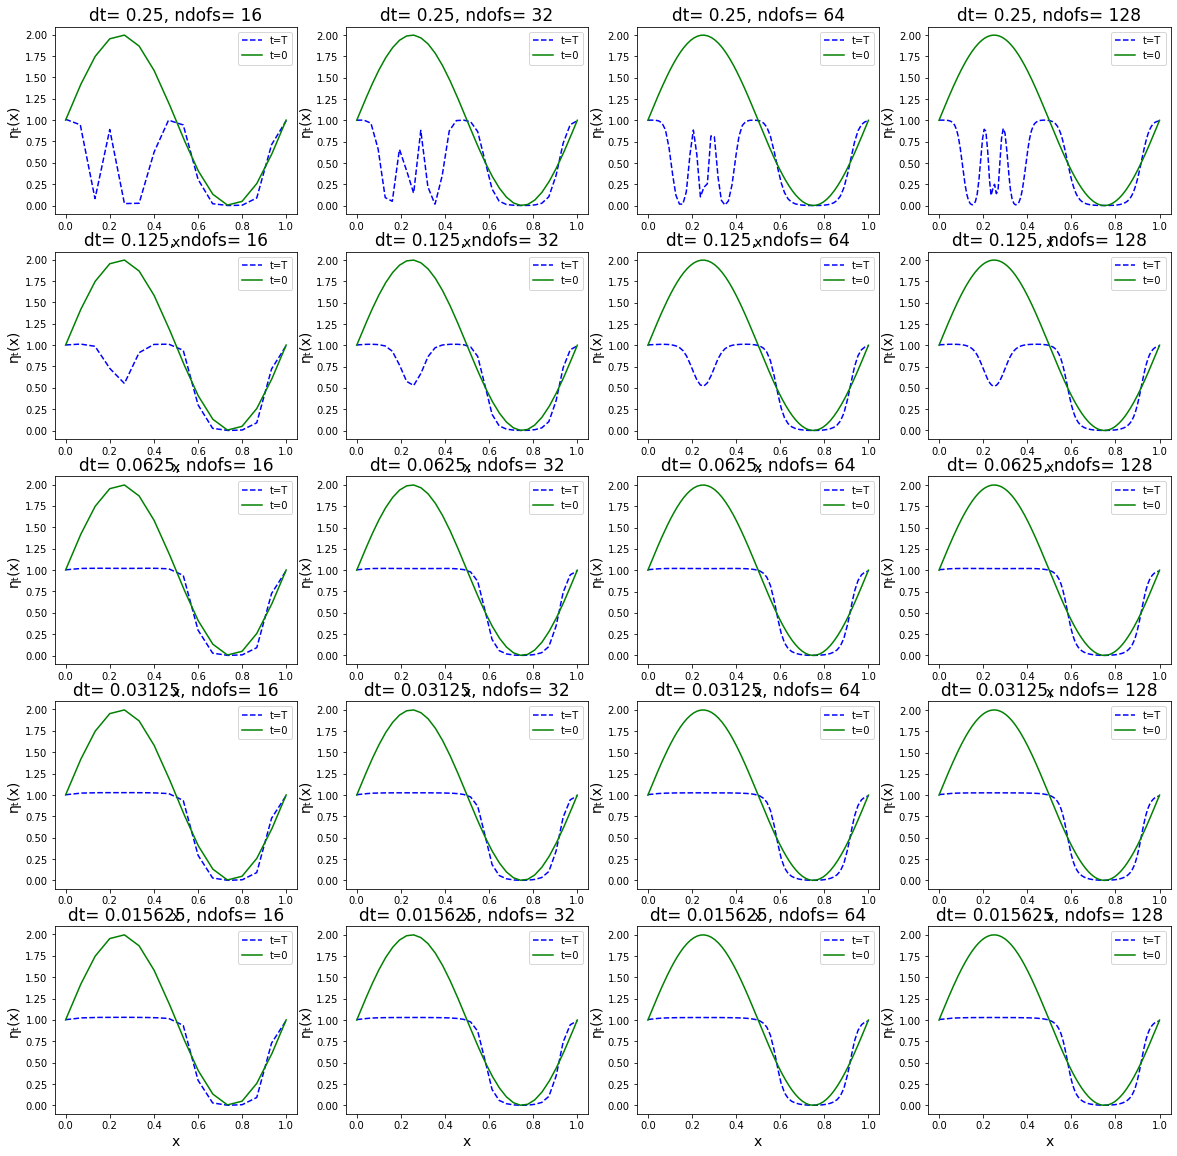

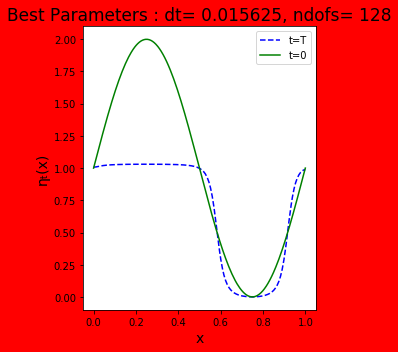

**** Solution : eps= 0.01, degree= 2




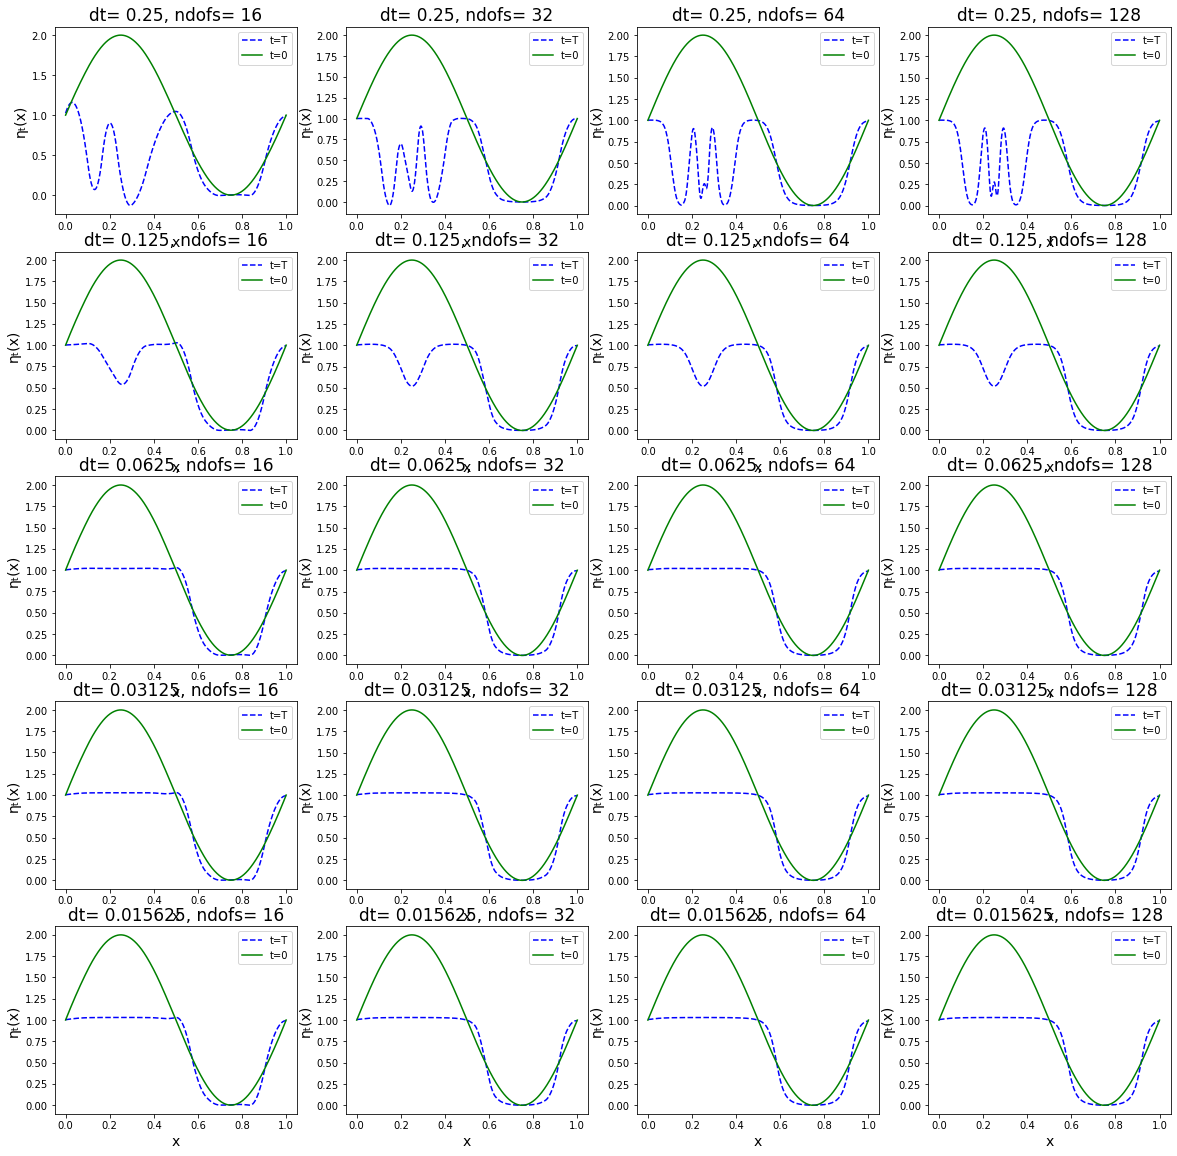

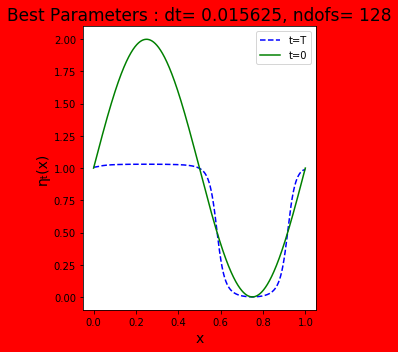

**** Solution : eps= 0.01, degree= 3




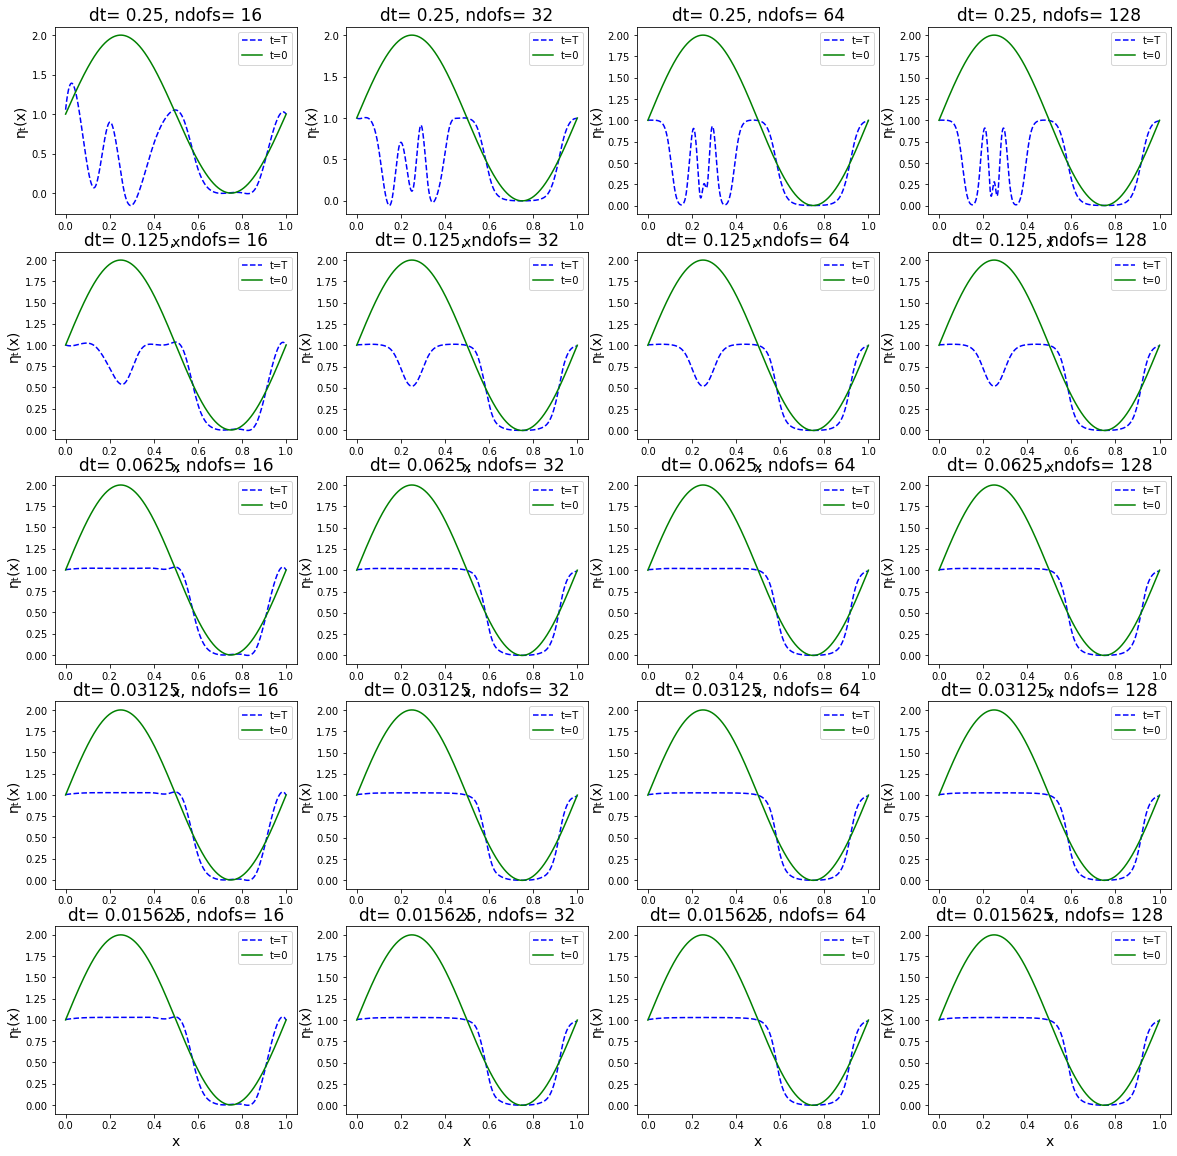

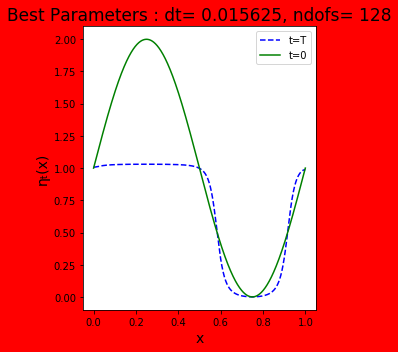

**** Solution : eps= 0.001, degree= 1




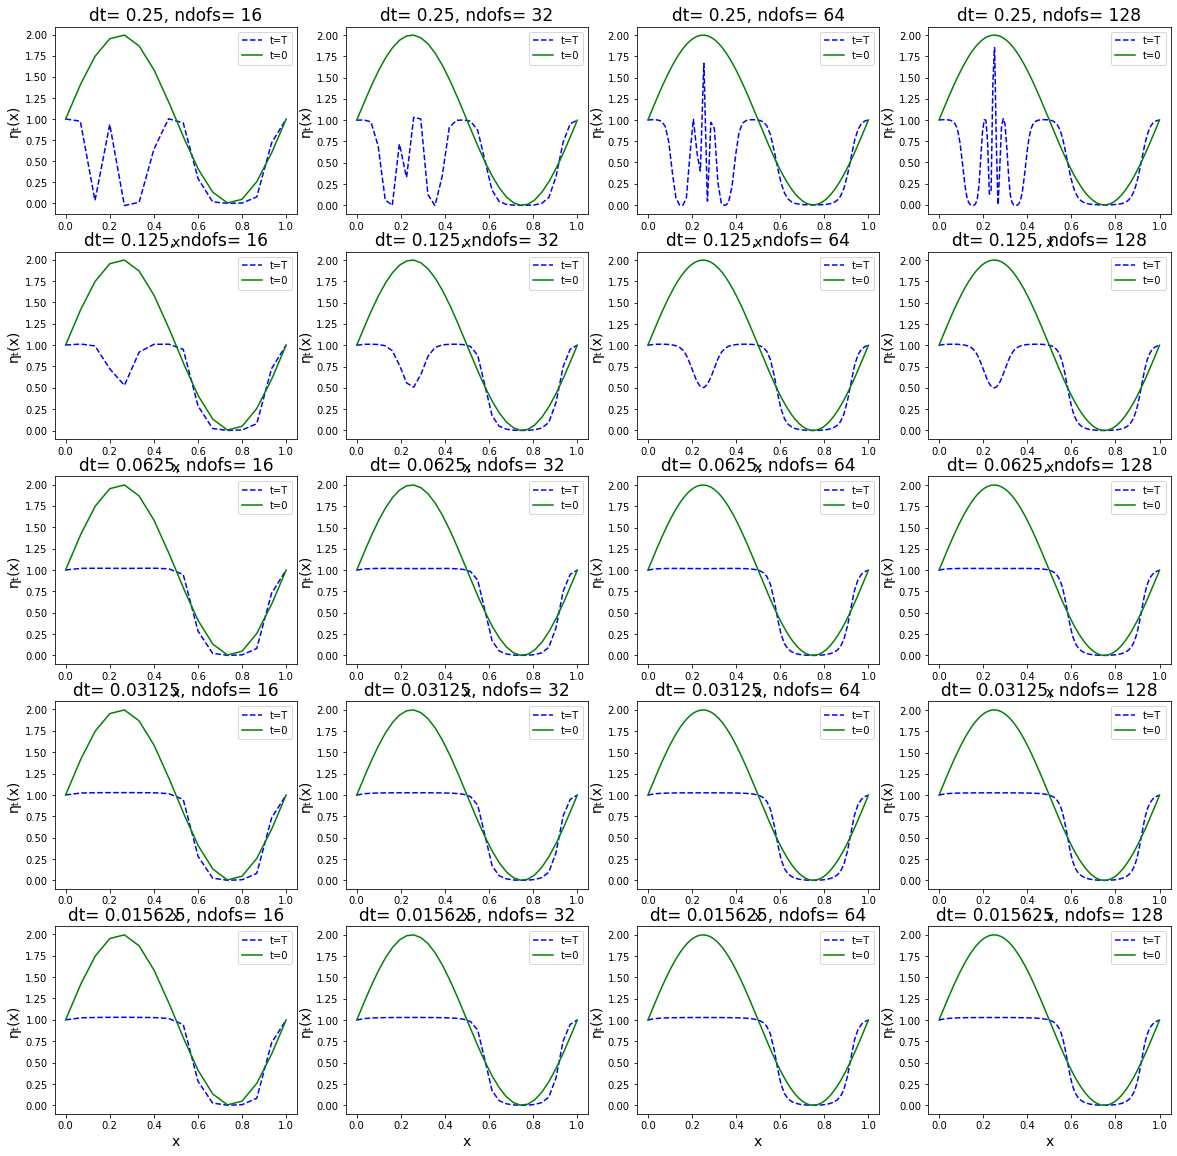

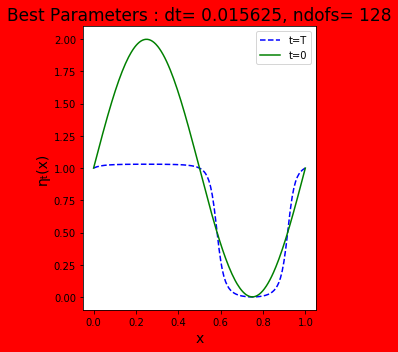

**** Solution : eps= 0.001, degree= 2




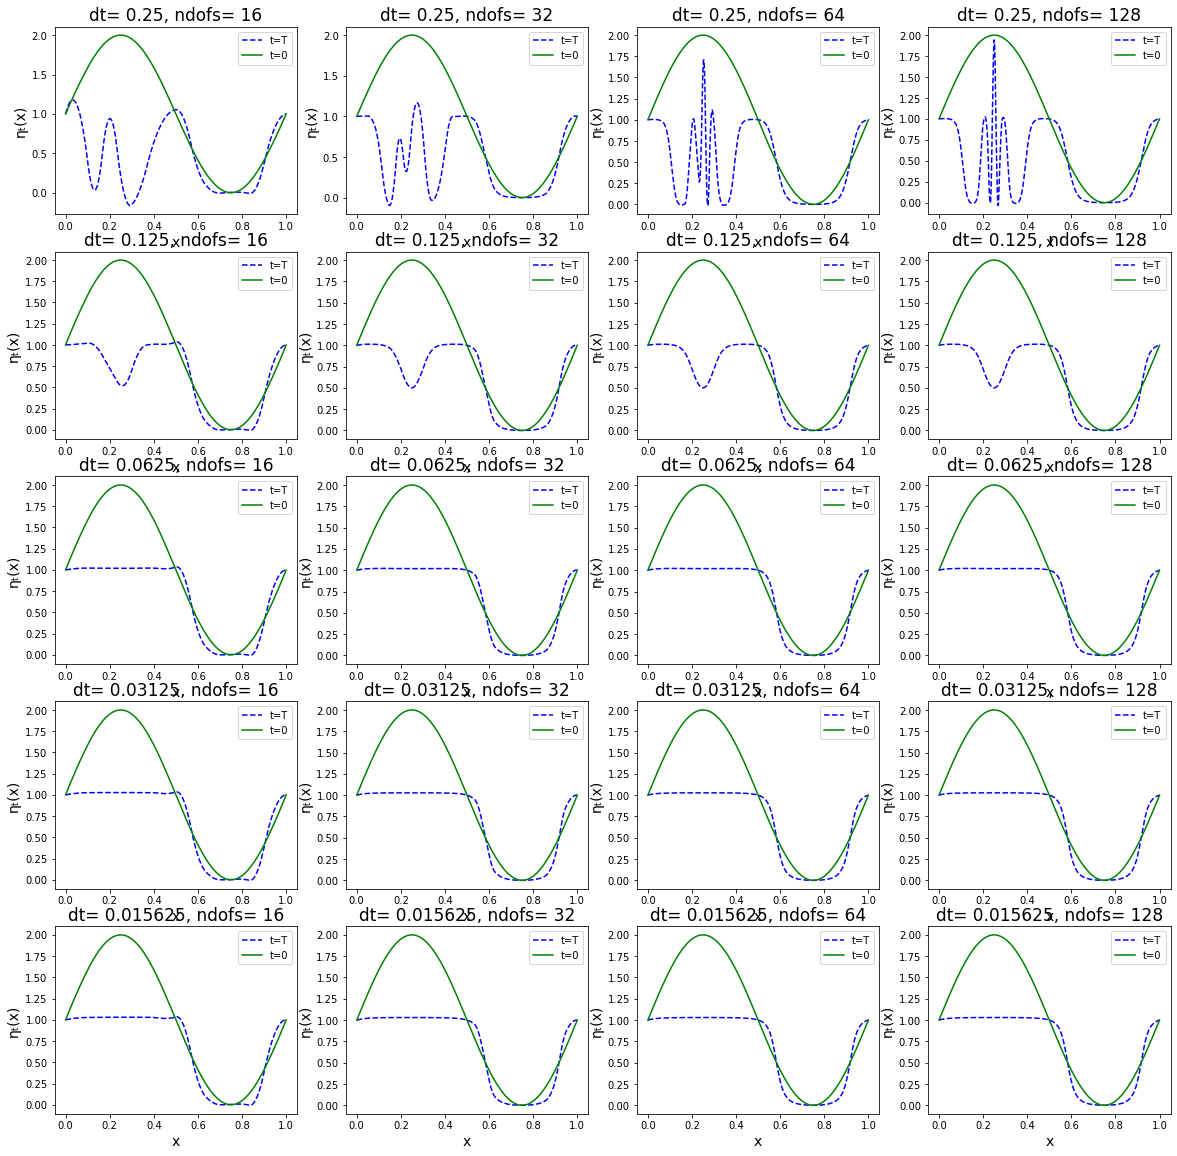

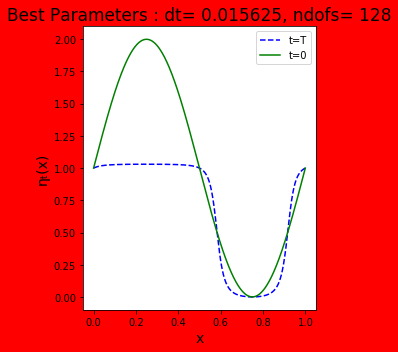

**** Solution : eps= 0.001, degree= 3




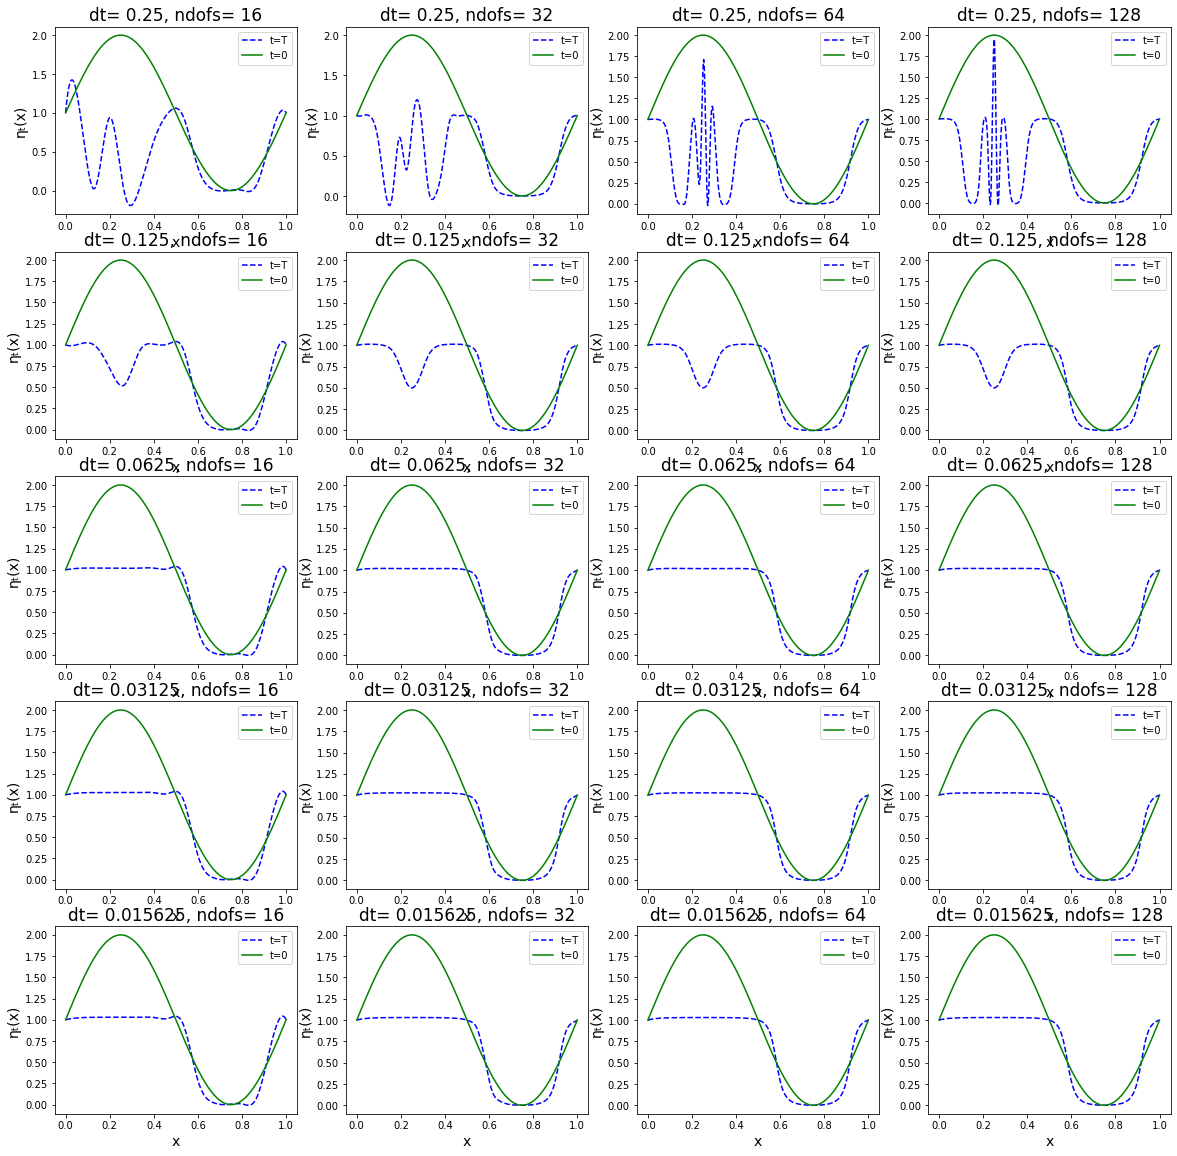

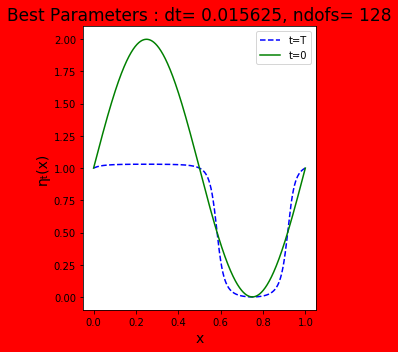

In [129]:
eps = [.01, .001]
degree = [1,2,3]
resolution = 1000
dt = [.25, .125, .0625, .03125, .015625]
ndofs = [16, 32, 64, 128]

for ep in eps:
    for de in degree:
        plot_grid(ep,de,resolution,dt,ndofs,initial = True)

### FInal Considerations about Forward Euler Methods

#### Factors for better accuracy

- increasing number of ndofs
- decreasing dt values
- decreasing timestemps range